### Imports

In [1]:
import pandas as pd
import numpy as np

#Python Standard Libs Imports
import json
import urllib2
import sys
from datetime import datetime
from os.path import isfile, join, splitext
from glob import glob

#Imports to enable visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Functions

#### Basic Functions

#### OTP Functions

#### Analysis Functions

### Main Code

#### Reading itinerary alternatives data

In [2]:
all_itineraries = pd.read_csv('/local/tarciso/data/its/itineraries/2017_06_21_itinerary.csv', parse_dates=['planned_start_time','actual_start_time','exec_start_time'])

In [3]:
all_itineraries.head()

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time
0,2017-06-21,6,0,3.883333,11.250000,11.250000,2017-06-21 20:56:07,2017-06-21 20:49:15,2017-06-21 20:49:15
1,2017-06-21,6,1,8.100000,9.033333,11.250000,2017-06-21 20:50:15,2017-06-21 20:40:58,2017-06-21 20:49:15
2,2017-06-21,6,2,4.150000,12.433333,11.250000,2017-06-21 20:56:07,2017-06-21 20:48:20,2017-06-21 20:49:15
3,2017-06-21,6,3,4.483333,4.416667,11.250000,2017-06-21 20:58:07,2017-06-21 20:48:40,2017-06-21 20:49:15
4,2017-06-21,28,0,38.216667,36.333333,36.333333,2017-06-21 08:05:47,2017-06-21 07:52:59,2017-06-21 07:52:59


In [4]:
all_itineraries.dtypes

date                             object
user_trip_id                      int64
itinerary_id                      int64
planned_duration_mins           float64
actual_duration_mins            float64
exec_duration_mins              float64
planned_start_time       datetime64[ns]
actual_start_time        datetime64[ns]
exec_start_time          datetime64[ns]
dtype: object

In [5]:
len(all_itineraries)

13072

In [6]:
len(all_itineraries.user_trip_id.unique())

3890

In [7]:
def get_trip_len_bucket(trip_duration):
    if (trip_duration < 10):
        return '<10'
    elif (trip_duration < 20):
        return '10-20'
    elif (trip_duration < 30):
        return '20-30'
    elif (trip_duration < 40):
        return '30-40'
    elif (trip_duration < 50):
        return '40-50'
    elif (trip_duration >= 50):
        return '50+'
    else:
        return 'NA'
    
def get_day_type(trip_start_time):
    trip_weekday = trip_start_time.weekday()
    if ((trip_weekday == 0) | (trip_weekday == 4)):
        return 'MON/FRI'
    elif ((trip_weekday > 0) & (trip_weekday < 4)):
        return 'TUE/WED/THU'
    elif (trip_weekday > 4):
        return 'SAT/SUN'
    else:
        return 'NA'


all_itineraries['trip_length_bucket'] = all_itineraries['exec_duration_mins'].apply(get_trip_len_bucket)
all_itineraries['hour_of_day'] = all_itineraries['exec_start_time'].dt.hour

period_of_day_list = [('hour_of_day', [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]),
         ('period_of_day', ['very_late_night','very_late_night','very_late_night','very_late_night','early_morning','early_morning','early_morning','morning','morning','morning','morning','midday','midday','midday','afternoon','afternoon','afternoon','evening','evening','evening','night','night','late_night','late_night'])]
period_of_day_df = pd.DataFrame.from_items(period_of_day_list)
period_of_day_df.period_of_day = period_of_day_df.period_of_day.astype('category', ordered=True)

all_itineraries = all_itineraries.merge(period_of_day_df, how='inner', on='hour_of_day')
all_itineraries['weekday'] = all_itineraries['exec_start_time'].apply(lambda x: x.weekday() < 5)
all_itineraries['day_type'] = all_itineraries['exec_start_time'].apply(get_day_type)

In [8]:
all_itineraries

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,trip_length_bucket,hour_of_day,period_of_day,weekday,day_type
0,2017-06-21,6,0,3.883333,11.250000,11.250000,2017-06-21 20:56:07,2017-06-21 20:49:15,2017-06-21 20:49:15,10-20,20,night,True,TUE/WED/THU
1,2017-06-21,6,1,8.100000,9.033333,11.250000,2017-06-21 20:50:15,2017-06-21 20:40:58,2017-06-21 20:49:15,10-20,20,night,True,TUE/WED/THU
2,2017-06-21,6,2,4.150000,12.433333,11.250000,2017-06-21 20:56:07,2017-06-21 20:48:20,2017-06-21 20:49:15,10-20,20,night,True,TUE/WED/THU
3,2017-06-21,6,3,4.483333,4.416667,11.250000,2017-06-21 20:58:07,2017-06-21 20:48:40,2017-06-21 20:49:15,10-20,20,night,True,TUE/WED/THU
4,2017-06-21,8589934636,0,NaN,27.816667,27.816667,NaT,2017-06-21 20:00:45,2017-06-21 20:00:45,20-30,20,night,True,TUE/WED/THU
5,2017-06-21,8589934636,1,23.066667,21.050000,27.816667,2017-06-21 20:09:03,2017-06-21 20:10:27,2017-06-21 20:00:45,20-30,20,night,True,TUE/WED/THU
6,2017-06-21,8589934636,2,21.916667,16.350000,27.816667,2017-06-21 20:14:52,2017-06-21 20:17:11,2017-06-21 20:00:45,20-30,20,night,True,TUE/WED/THU
7,2017-06-21,17179869220,0,NaN,14.616667,14.616667,NaT,2017-06-21 20:46:51,2017-06-21 20:46:51,10-20,20,night,True,TUE/WED/THU
8,2017-06-21,17179869220,1,13.666667,13.950000,14.616667,2017-06-21 21:08:52,2017-06-21 20:49:57,2017-06-21 20:46:51,10-20,20,night,True,TUE/WED/THU
9,2017-06-21,17179869220,2,16.133333,12.483333,14.616667,2017-06-21 21:33:03,2017-06-21 21:32:34,2017-06-21 20:46:51,10-20,20,night,True,TUE/WED/THU


In [44]:
analysis_cols = ['trip_length_bucket','hour_of_day','period_of_day','weekday','day_type']

#### Filtering trips for whose executed itineraries there is no schedule information

In [9]:
def filter_trips_alternatives(trips_alternatives):
    min_trip_dur = 10
    max_trip_dur = 50
    max_trip_start_diff = 20
    
    return trips_alternatives[(trips_alternatives['actual_duration_mins'] >= min_trip_dur) & (trips_alternatives['actual_duration_mins'] <= max_trip_dur)] \
                                    .assign(start_diff = lambda x: np.absolute(x['exec_start_time'] - x['actual_start_time'])/pd.Timedelta(minutes=1)) \
                                    [lambda x: x['start_diff'] <= 20]

In [10]:
def filter_trips_with_insufficient_alternatives(trips_alternatives):
    num_trips_alternatives = trips_alternatives.groupby(['date','user_trip_id']).size().reset_index(name='num_alternatives')
    trips_with_executed_alternative = trips_alternatives[trips_alternatives['itinerary_id'] == 0][['date','user_trip_id']]
    
    return trips_alternatives.merge(trips_with_executed_alternative, on=['date','user_trip_id'], how='inner') \
                .merge(num_trips_alternatives, on=['date','user_trip_id'], how='inner') \
                [lambda x: x['num_alternatives'] > 1] \
                .sort_values(['user_trip_id','itinerary_id'])   

In [11]:
clean_itineraries = filter_trips_with_insufficient_alternatives(filter_trips_alternatives(all_itineraries))

In [12]:
clean_itineraries.head()

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,trip_length_bucket,hour_of_day,period_of_day,weekday,day_type,start_diff,num_alternatives
0,2017-06-21,6,0,3.883333,11.250000,11.250000,2017-06-21 20:56:07,2017-06-21 20:49:15,2017-06-21 20:49:15,10-20,20,night,True,TUE/WED/THU,0.000000,2
1,2017-06-21,6,2,4.150000,12.433333,11.250000,2017-06-21 20:56:07,2017-06-21 20:48:20,2017-06-21 20:49:15,10-20,20,night,True,TUE/WED/THU,0.916667,2
80,2017-06-21,28,0,38.216667,36.333333,36.333333,2017-06-21 08:05:47,2017-06-21 07:52:59,2017-06-21 07:52:59,30-40,7,morning,True,TUE/WED/THU,0.000000,2
81,2017-06-21,28,1,38.333333,41.750000,36.333333,2017-06-21 08:05:47,2017-06-21 08:05:00,2017-06-21 07:52:59,30-40,7,morning,True,TUE/WED/THU,12.016667,2
1325,2017-06-21,121,0,25.550000,16.066667,16.066667,2017-06-21 16:44:56,2017-06-21 16:44:09,2017-06-21 16:44:09,10-20,16,afternoon,True,TUE/WED/THU,0.000000,2


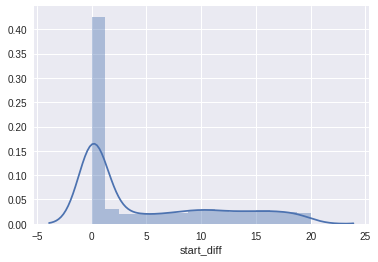

In [13]:
sns.distplot(clean_itineraries['start_diff'])

In [14]:
len(clean_itineraries)

3961

In [15]:
len(clean_itineraries.user_trip_id.unique())

1522

In [16]:
exec_itineraries_with_scheduled_info = all_itineraries[(all_itineraries['itinerary_id'] == 0) & (pd.notnull(all_itineraries['planned_duration_mins']))][['user_trip_id']]

In [17]:
exec_itineraries_with_scheduled_info.head()

,user_trip_id
0,6
21,51539607613
31,94489280633
39,103079215204
43,111669149834


In [18]:
clean_itineraries2 = filter_trips_with_insufficient_alternatives(filter_trips_alternatives(all_itineraries.merge(exec_itineraries_with_scheduled_info, on='user_trip_id', how='inner')))

In [19]:
clean_itineraries2.head(20)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,trip_length_bucket,hour_of_day,period_of_day,weekday,day_type,start_diff,num_alternatives
0,2017-06-21,6,0,3.883333,11.250000,11.250000,2017-06-21 20:56:07,2017-06-21 20:49:15,2017-06-21 20:49:15,10-20,20,night,True,TUE/WED/THU,0.000000,2
1,2017-06-21,6,2,4.150000,12.433333,11.250000,2017-06-21 20:56:07,2017-06-21 20:48:20,2017-06-21 20:49:15,10-20,20,night,True,TUE/WED/THU,0.916667,2
33,2017-06-21,28,0,38.216667,36.333333,36.333333,2017-06-21 08:05:47,2017-06-21 07:52:59,2017-06-21 07:52:59,30-40,7,morning,True,TUE/WED/THU,0.000000,2
34,2017-06-21,28,1,38.333333,41.750000,36.333333,2017-06-21 08:05:47,2017-06-21 08:05:00,2017-06-21 07:52:59,30-40,7,morning,True,TUE/WED/THU,12.016667,2
676,2017-06-21,121,0,25.550000,16.066667,16.066667,2017-06-21 16:44:56,2017-06-21 16:44:09,2017-06-21 16:44:09,10-20,16,afternoon,True,TUE/WED/THU,0.000000,2
677,2017-06-21,121,1,26.416667,17.000000,16.066667,2017-06-21 16:44:56,2017-06-21 16:44:05,2017-06-21 16:44:09,10-20,16,afternoon,True,TUE/WED/THU,0.066667,2
1117,2017-06-21,17179869186,0,26.916667,23.466667,23.466667,2017-06-21 10:00:05,2017-06-21 09:52:06,2017-06-21 09:52:06,20-30,9,morning,True,TUE/WED/THU,0.000000,3
1118,2017-06-21,17179869186,1,29.850000,27.200000,23.466667,2017-06-21 10:00:05,2017-06-21 09:51:18,2017-06-21 09:52:06,20-30,9,morning,True,TUE/WED/THU,0.800000,3
1119,2017-06-21,17179869186,2,29.850000,27.200000,23.466667,2017-06-21 10:15:05,2017-06-21 09:51:18,2017-06-21 09:52:06,20-30,9,morning,True,TUE/WED/THU,0.800000,3
36,2017-06-21,17179869211,0,38.216667,44.266667,44.266667,2017-06-21 08:05:47,2017-06-21 07:45:46,2017-06-21 07:45:46,40-50,7,morning,True,TUE/WED/THU,0.000000,2


In [20]:
len(clean_itineraries2)

1997

In [21]:
len(clean_itineraries2.user_trip_id.unique())

771

### Compute Inefficiency Metrics

![title](img/math_model.png)

In [22]:
def select_best_itineraries(trips_itineraries,metric_name):
    return trips_itineraries.sort_values([metric_name]) \
                        .groupby(['date','user_trip_id']) \
                        .nth(0) \
                        .reset_index()

#### Observed Inefficiency

In [23]:
#Choose best itinerary for each trip by selecting the ones with lower actual duration
best_trips_itineraries = select_best_itineraries(clean_itineraries,'actual_duration_mins')

In [24]:
best_trips_itineraries.head()

,date,user_trip_id,actual_duration_mins,actual_start_time,day_type,exec_duration_mins,exec_start_time,hour_of_day,itinerary_id,num_alternatives,period_of_day,planned_duration_mins,planned_start_time,start_diff,trip_length_bucket,weekday
0,2017-06-21,6,11.250000,2017-06-21 20:49:15,TUE/WED/THU,11.250000,2017-06-21 20:49:15,20,0,2,night,3.883333,2017-06-21 20:56:07,0.000000,10-20,True
1,2017-06-21,28,36.333333,2017-06-21 07:52:59,TUE/WED/THU,36.333333,2017-06-21 07:52:59,7,0,2,morning,38.216667,2017-06-21 08:05:47,0.000000,30-40,True
2,2017-06-21,121,16.066667,2017-06-21 16:44:09,TUE/WED/THU,16.066667,2017-06-21 16:44:09,16,0,2,afternoon,25.550000,2017-06-21 16:44:56,0.000000,10-20,True
3,2017-06-21,8589934632,16.283333,2017-06-21 09:17:09,TUE/WED/THU,25.933333,2017-06-21 09:06:08,9,1,3,morning,21.200000,2017-06-21 09:14:11,11.016667,20-30,True
4,2017-06-21,8589934636,16.350000,2017-06-21 20:17:11,TUE/WED/THU,27.816667,2017-06-21 20:00:45,20,2,3,night,21.916667,2017-06-21 20:14:52,16.433333,20-30,True


In [25]:
trips_inefficiency = best_trips_itineraries \
                        .assign(dur_diff = lambda x: x['exec_duration_mins'] - x['actual_duration_mins']) \
                        .assign(observed_inef = lambda x: x['dur_diff']/x['exec_duration_mins'])

In [26]:
trips_inefficiency.head(10)

,date,user_trip_id,actual_duration_mins,actual_start_time,day_type,exec_duration_mins,exec_start_time,hour_of_day,itinerary_id,num_alternatives,period_of_day,planned_duration_mins,planned_start_time,start_diff,trip_length_bucket,weekday,dur_diff,observed_inef
0,2017-06-21,6,11.250000,2017-06-21 20:49:15,TUE/WED/THU,11.250000,2017-06-21 20:49:15,20,0,2,night,3.883333,2017-06-21 20:56:07,0.000000,10-20,True,0.000000,0.000000
1,2017-06-21,28,36.333333,2017-06-21 07:52:59,TUE/WED/THU,36.333333,2017-06-21 07:52:59,7,0,2,morning,38.216667,2017-06-21 08:05:47,0.000000,30-40,True,0.000000,0.000000
2,2017-06-21,121,16.066667,2017-06-21 16:44:09,TUE/WED/THU,16.066667,2017-06-21 16:44:09,16,0,2,afternoon,25.550000,2017-06-21 16:44:56,0.000000,10-20,True,0.000000,0.000000
3,2017-06-21,8589934632,16.283333,2017-06-21 09:17:09,TUE/WED/THU,25.933333,2017-06-21 09:06:08,9,1,3,morning,21.200000,2017-06-21 09:14:11,11.016667,20-30,True,9.650000,0.372108
4,2017-06-21,8589934636,16.350000,2017-06-21 20:17:11,TUE/WED/THU,27.816667,2017-06-21 20:00:45,20,2,3,night,21.916667,2017-06-21 20:14:52,16.433333,20-30,True,11.466667,0.412223
5,2017-06-21,8589934663,24.133333,2017-06-21 19:43:33,TUE/WED/THU,30.316667,2017-06-21 19:32:44,19,1,2,evening,31.583333,2017-06-21 19:38:03,10.816667,30-40,True,6.183333,0.203958
6,2017-06-21,8589934675,25.083333,2017-06-21 07:45:31,TUE/WED/THU,33.183333,2017-06-21 07:45:34,7,1,2,morning,26.783333,2017-06-21 07:45:45,0.050000,30-40,True,8.100000,0.244098
7,2017-06-21,8589934748,26.600000,2017-06-21 15:44:56,TUE/WED/THU,26.600000,2017-06-21 15:44:56,15,0,2,afternoon,NaN,NaT,0.000000,20-30,True,0.000000,0.000000
8,2017-06-21,17179869186,23.466667,2017-06-21 09:52:06,TUE/WED/THU,23.466667,2017-06-21 09:52:06,9,0,3,morning,26.916667,2017-06-21 10:00:05,0.000000,20-30,True,0.000000,0.000000
9,2017-06-21,17179869211,41.750000,2017-06-21 08:05:00,TUE/WED/THU,44.266667,2017-06-21 07:45:46,7,1,2,morning,38.333333,2017-06-21 08:05:47,19.233333,40-50,True,2.516667,0.056852


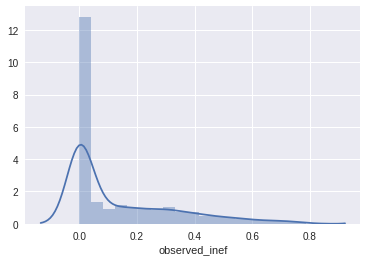

In [27]:
sns.distplot(trips_inefficiency.observed_inef)

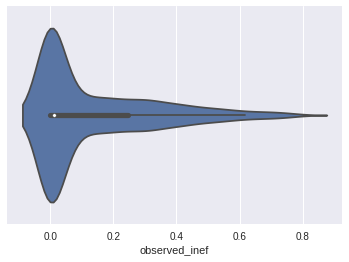

In [28]:
sns.violinplot(trips_inefficiency.observed_inef)

In [29]:
pos_trips_inefficiency = trips_inefficiency[trips_inefficiency['dur_diff'] > 1]

In [30]:
pos_trips_inefficiency.head()

,date,user_trip_id,actual_duration_mins,actual_start_time,day_type,exec_duration_mins,exec_start_time,hour_of_day,itinerary_id,num_alternatives,period_of_day,planned_duration_mins,planned_start_time,start_diff,trip_length_bucket,weekday,dur_diff,observed_inef
3,2017-06-21,8589934632,16.283333,2017-06-21 09:17:09,TUE/WED/THU,25.933333,2017-06-21 09:06:08,9,1,3,morning,21.200000,2017-06-21 09:14:11,11.016667,20-30,True,9.650000,0.372108
4,2017-06-21,8589934636,16.350000,2017-06-21 20:17:11,TUE/WED/THU,27.816667,2017-06-21 20:00:45,20,2,3,night,21.916667,2017-06-21 20:14:52,16.433333,20-30,True,11.466667,0.412223
5,2017-06-21,8589934663,24.133333,2017-06-21 19:43:33,TUE/WED/THU,30.316667,2017-06-21 19:32:44,19,1,2,evening,31.583333,2017-06-21 19:38:03,10.816667,30-40,True,6.183333,0.203958
6,2017-06-21,8589934675,25.083333,2017-06-21 07:45:31,TUE/WED/THU,33.183333,2017-06-21 07:45:34,7,1,2,morning,26.783333,2017-06-21 07:45:45,0.050000,30-40,True,8.100000,0.244098
9,2017-06-21,17179869211,41.750000,2017-06-21 08:05:00,TUE/WED/THU,44.266667,2017-06-21 07:45:46,7,1,2,morning,38.333333,2017-06-21 08:05:47,19.233333,40-50,True,2.516667,0.056852


#### Schedule Inefficiency

In [31]:
shortest_planned_itineraries = select_best_itineraries(clean_itineraries[pd.notnull(clean_itineraries['planned_duration_mins'])],'planned_duration_mins') \
                            [['date','user_trip_id','planned_duration_mins','actual_duration_mins']] \
                            .rename(index=str,columns={'planned_duration_mins':'shortest_scheduled_planned_duration',
                                               'actual_duration_mins':'shortest_scheduled_observed_duration'})

shortest_planned_itineraries.head()

,date,user_trip_id,shortest_scheduled_planned_duration,shortest_scheduled_observed_duration
0,2017-06-21,6,3.883333,11.250000
1,2017-06-21,28,38.216667,36.333333
2,2017-06-21,121,25.550000,16.066667
3,2017-06-21,8589934632,21.200000,16.283333
4,2017-06-21,8589934636,21.916667,16.350000


In [47]:
rec_inef_i = best_trips_itineraries \
                .rename(index=str,columns={'actual_duration_mins':'shortest_observed_duration'}) \
                .merge(shortest_planned_itineraries, on=['date','user_trip_id'], how='inner') \
                .assign(rec_inef = lambda x: (x['shortest_scheduled_observed_duration'] - x['shortest_observed_duration'])/x['shortest_scheduled_observed_duration'])

rec_inef_i.head()

,date,user_trip_id,shortest_observed_duration,actual_start_time,day_type,exec_duration_mins,exec_start_time,hour_of_day,itinerary_id,num_alternatives,period_of_day,planned_duration_mins,planned_start_time,start_diff,trip_length_bucket,weekday,shortest_scheduled_planned_duration,shortest_scheduled_observed_duration,rec_inef
0,2017-06-21,6,11.250000,2017-06-21 20:49:15,TUE/WED/THU,11.250000,2017-06-21 20:49:15,20,0,2,night,3.883333,2017-06-21 20:56:07,0.000000,10-20,True,3.883333,11.250000,0.0
1,2017-06-21,28,36.333333,2017-06-21 07:52:59,TUE/WED/THU,36.333333,2017-06-21 07:52:59,7,0,2,morning,38.216667,2017-06-21 08:05:47,0.000000,30-40,True,38.216667,36.333333,0.0
2,2017-06-21,121,16.066667,2017-06-21 16:44:09,TUE/WED/THU,16.066667,2017-06-21 16:44:09,16,0,2,afternoon,25.550000,2017-06-21 16:44:56,0.000000,10-20,True,25.550000,16.066667,0.0
3,2017-06-21,8589934632,16.283333,2017-06-21 09:17:09,TUE/WED/THU,25.933333,2017-06-21 09:06:08,9,1,3,morning,21.200000,2017-06-21 09:14:11,11.016667,20-30,True,21.200000,16.283333,0.0
4,2017-06-21,8589934636,16.350000,2017-06-21 20:17:11,TUE/WED/THU,27.816667,2017-06-21 20:00:45,20,2,3,night,21.916667,2017-06-21 20:14:52,16.433333,20-30,True,21.916667,16.350000,0.0


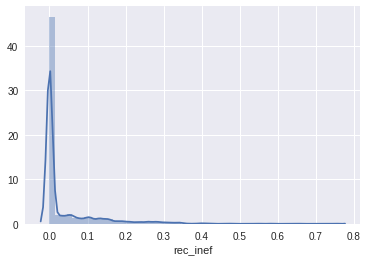

In [50]:
sns.distplot(rec_inef_i.rec_inef)

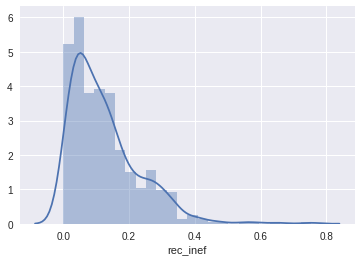

In [48]:
sns.distplot(rec_inef_i[rec_inef_i['rec_inef'] > 0].rec_inef)

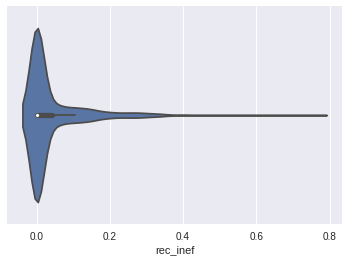

In [49]:
sns.violinplot(rec_inef_i.rec_inef)

#### User choice plan inefficiency

In [35]:
best_scheduled_itineraries = select_best_itineraries(clean_itineraries2,'planned_duration_mins') \
                                [['date','user_trip_id','planned_duration_mins']] \
                                .rename(index=str,columns={'planned_duration_mins':'best_planned_duration_mins'})

In [36]:
best_scheduled_itineraries.head()

,date,user_trip_id,best_planned_duration_mins
0,2017-06-21,6,3.883333
1,2017-06-21,28,38.216667
2,2017-06-21,121,25.550000
3,2017-06-21,17179869186,26.916667
4,2017-06-21,17179869211,38.216667


In [37]:
plan_inef = clean_itineraries2.merge(best_scheduled_itineraries, on=['date','user_trip_id'], how='inner') \
                [lambda x: x['itinerary_id'] == 0] \
                [['date','user_trip_id','planned_duration_mins','best_planned_duration_mins']] \
                .assign(plan_inef = lambda x: (x['planned_duration_mins'] - x['best_planned_duration_mins'])/(x['planned_duration_mins']))

In [38]:
plan_inef.head()

,date,user_trip_id,planned_duration_mins,best_planned_duration_mins,plan_inef
0,2017-06-21,6,3.883333,3.883333,0.0
2,2017-06-21,28,38.216667,38.216667,0.0
4,2017-06-21,121,25.550000,25.550000,0.0
6,2017-06-21,17179869186,26.916667,26.916667,0.0
9,2017-06-21,17179869211,38.216667,38.216667,0.0


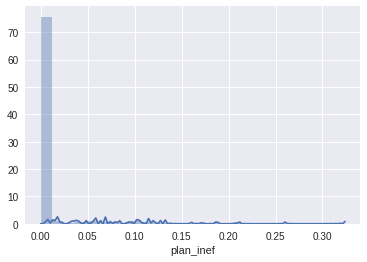

In [39]:
sns.distplot(plan_inef.plan_inef)

#### System Schedule Deviation
$$
\begin{equation*}
    {Oe - Op}
\end{equation*}
$$

In [40]:
sched_deviation = clean_itineraries[clean_itineraries['itinerary_id'] > 0] \
                    .assign(sched_dev = lambda x: x['actual_duration_mins'] - x['planned_duration_mins'])
    
sched_deviation.head()

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,trip_length_bucket,hour_of_day,period_of_day,weekday,day_type,start_diff,num_alternatives,sched_dev
1,2017-06-21,6,2,4.150000,12.433333,11.250000,2017-06-21 20:56:07,2017-06-21 20:48:20,2017-06-21 20:49:15,10-20,20,night,True,TUE/WED/THU,0.916667,2,8.283333
81,2017-06-21,28,1,38.333333,41.750000,36.333333,2017-06-21 08:05:47,2017-06-21 08:05:00,2017-06-21 07:52:59,30-40,7,morning,True,TUE/WED/THU,12.016667,2,3.416667
1326,2017-06-21,121,1,26.416667,17.000000,16.066667,2017-06-21 16:44:56,2017-06-21 16:44:05,2017-06-21 16:44:09,10-20,16,afternoon,True,TUE/WED/THU,0.066667,2,-9.416667
2352,2017-06-21,8589934632,1,21.200000,16.283333,25.933333,2017-06-21 09:14:11,2017-06-21 09:17:09,2017-06-21 09:06:08,20-30,9,morning,True,TUE/WED/THU,11.016667,3,-4.916667
2353,2017-06-21,8589934632,2,23.750000,19.433333,25.933333,2017-06-21 09:23:10,2017-06-21 09:23:20,2017-06-21 09:06:08,20-30,9,morning,True,TUE/WED/THU,17.200000,3,-4.316667


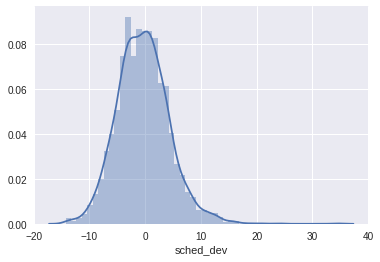

In [41]:
sns.distplot(sched_deviation.sched_dev)

#### User stop waiting time offset
$$
\begin{equation*}
    {start(Oe) - start(Op)}
\end{equation*}
$$

In [42]:
user_boarding_timediff = clean_itineraries[clean_itineraries['itinerary_id'] > 0] \
                    .assign(boarding_timediff = lambda x: (x['actual_start_time'] - x['planned_start_time'])/pd.Timedelta(minutes=1))
    
user_boarding_timediff.head()

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,trip_length_bucket,hour_of_day,period_of_day,weekday,day_type,start_diff,num_alternatives,boarding_timediff
1,2017-06-21,6,2,4.150000,12.433333,11.250000,2017-06-21 20:56:07,2017-06-21 20:48:20,2017-06-21 20:49:15,10-20,20,night,True,TUE/WED/THU,0.916667,2,-7.783333
81,2017-06-21,28,1,38.333333,41.750000,36.333333,2017-06-21 08:05:47,2017-06-21 08:05:00,2017-06-21 07:52:59,30-40,7,morning,True,TUE/WED/THU,12.016667,2,-0.783333
1326,2017-06-21,121,1,26.416667,17.000000,16.066667,2017-06-21 16:44:56,2017-06-21 16:44:05,2017-06-21 16:44:09,10-20,16,afternoon,True,TUE/WED/THU,0.066667,2,-0.850000
2352,2017-06-21,8589934632,1,21.200000,16.283333,25.933333,2017-06-21 09:14:11,2017-06-21 09:17:09,2017-06-21 09:06:08,20-30,9,morning,True,TUE/WED/THU,11.016667,3,2.966667
2353,2017-06-21,8589934632,2,23.750000,19.433333,25.933333,2017-06-21 09:23:10,2017-06-21 09:23:20,2017-06-21 09:06:08,20-30,9,morning,True,TUE/WED/THU,17.200000,3,0.166667


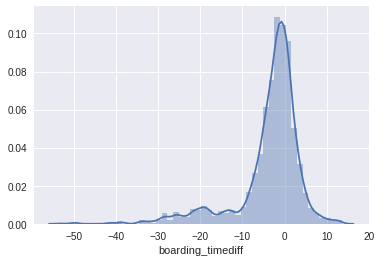

In [43]:
sns.distplot(user_boarding_timediff.boarding_timediff)

#### Adding metadata for further analysis